In [1]:
import scipy.signal as signal 

In [2]:
import pandas as pd
import soundfile as sf
from measure_horseshoe_bat_calls.simulate_calls import make_cffm_call
from measure_horseshoe_bat_calls.signal_processing import *
from measure_horseshoe_bat_calls.view_horseshoebat_call import *
from measure_horseshoe_bat_calls.user_interface import segment_and_measure_call
from measure_horseshoe_bat_calls.batch_processing import load_raw_audio
from measure_horseshoe_bat_calls.segment_horseshoebat_call import *

In [3]:
%matplotlib notebook

In [4]:


def segment_and_show_cffm(call_and_fs, **kwargs):
    ''' Function taken from notebook: Trying out new world bat recordings...'''
    call, fs = call_and_fs
    peak_freq, _ = get_peak_frequency(call, fs)
    (cf,fm,_), _ , measurements,_ = segment_and_measure_call(call,fs,**kwargs)
    w,s = visualise_call(call,fs)
    s.set_ylim(20000,peak_freq*1.5)
    w.plot(make_x_time(call,fs),cf*np.max(call), 'k', label='CF')
    w.plot(make_x_time(call,fs),fm*np.max(call), 'r', label='FM')
    w.legend()
    s.plot(make_x_time(call,fs),cf*peak_freq*1.1, 'w')
    s.plot(make_x_time(call,fs),fm*peak_freq*1.1, 'r')
    return w,s 

<IPython.core.display.Javascript object>


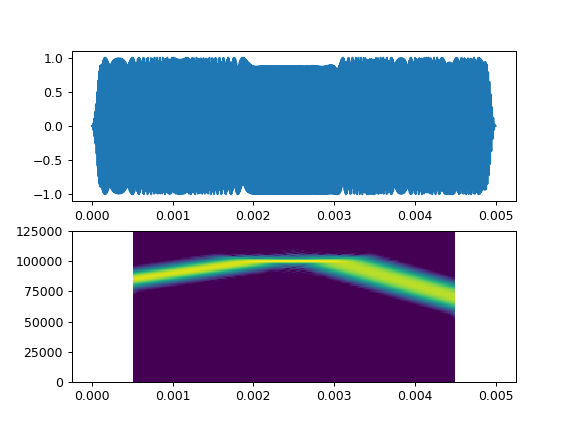

(0, 125000)

In [5]:
call_parameters = {'cf':(100000, 0.001),
                    'upfm':(80000, 0.002),
                    'downfm':(60000, 0.002),
                    }

syn_fs = 500*10**3 # 500kHz sampling rate
synthetic_call, freq_profile = make_cffm_call(call_parameters, syn_fs)
synthetic_call *= signal.tukey(synthetic_call.size, 0.05)
# plot
wavef, spec = visualise_call(synthetic_call, syn_fs, fft_size=512)
spec.set_ylim(0,125000)


### Tracking frequency of a natural bat call:

In [6]:
filename = 'gg_leporinus4_4603-4621ms_GG-USG2017-03-17_20-27-53_0038verygood_snippet.wav'
fs = sf.info(filename).samplerate
leporinus, _ = sf.read(filename, start=int(0.0018*fs), stop=-int(0.002*fs))

<IPython.core.display.Javascript object>


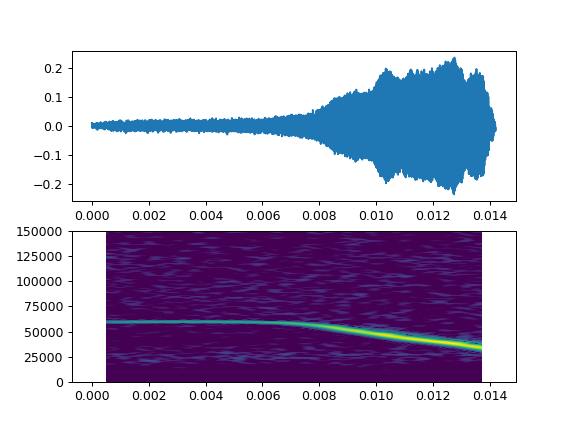

(<matplotlib.axes._subplots.AxesSubplot at 0x102a7dc8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13e85808>)

In [7]:
visualise_call(leporinus, fs)


This kind of call (from *N. leporinus* isn't handled well, because it's got an odd envelope. Even though the CF is *not* short, the tail FM is so dominant that the peak frequency gets shifted below. 

In [110]:
def instantaneous_frequency_profile(audio, fs, **kwargs):
    hil = signal.hilbert(audio)
    instantaneous_phase = np.unwrap(np.angle(hil))
    instantaneous_frequency = (np.diff(instantaneous_phase)/(2.0*np.pi)) * fs
    instant_frequency_resized = resize_by_adding_one_sample(instantaneous_frequency, audio, **kwargs)
    return instant_frequency_resized



def calc_proper_kernel_size(durn, fs):
    '''scipy.signal.medfilt requires an odd number of samples as
    kernel_size. This function calculates the number of samples
    for a given duration which is odd and is close to the 
    required duration. 
    
    Parameters
    ----------
    durn : float
        Duration in seconds. 
    fs : float
        Sampling rate in Hz
    
    Returns
    -------
    samples : int
        Number of odd samples that is equal to or little 
        less (by one sample) than the input duration. 
    '''
    samples = int(durn*fs)
    if np.remainder(samples,2)==0:
        samples -= 1
    return samples

def resize_by_adding_one_sample(input_signal, original_signal, **kwargs):
    '''Resizes the input_signal to the same size as the original signal by repeating one
    sample value. The sample value can either the last or the first sample of the input_signal. 
    '''
    check_signal_sizes(input_signal, original_signal)
    
    repeat_start = kwargs.get('repeat_start', True)
    
    if repeat_start:
        return np.concatenate((np.array([input_signal[0]]), input_signal))
    else:
        return np.concatenate((input_signal, np.array([input_signal[-1]])))


def check_signal_sizes(input_signal, original_signal):
    if int(input_signal.size) >= int(original_signal.size):
        msg1 = 'The input signal"s size %d'%int(input_signal.size)
        msg2 = ' is greater or equal to the original signal"s size: %d'%(int(original_signal.size))
        raise ValueError(msg1+msg2)
    
    if int(original_signal.size) - int(input_signal.size) >= 2:
        raise ValueError('The original signal is >= 2 samples longer than the input signal.')
    

def median_filter(input_signal, fs, **kwargs):
    '''Median filters a signal according to a user-settable
    window size. 

    Parameters
    ----------
    input_signal : np.array
    fs : float
        Sampling rate in Hz.
    medianfilter_size : float, optional
        The window size in seconds. Defaults to 0.001 seconds. 

    Returns
    -------
    med_filtered : np.array
        Median filtered version of the input_signal. 
    '''
    window_duration = kwargs.get('medianfilter_size',
                              0.001)
    kernel_size = calc_proper_kernel_size(window_duration, fs)
    med_filtered = signal.medfilt(input_signal, kernel_size)
    return med_filtered

def identify_cf_ish_regions(frequency_profile, fs, **kwargs):
    '''Identifies CF regions by comparing the rate of frequency modulation 
    across the signal. If the frequency modulation within a region of 
    the signal is less than the limit then it is considered a CF region. 

    Parameters
    ----------
    frequency_profile : np.array
        The instantaneous frequency of the signal over time in Hz. 
    fm_limit : float, optional 
        The maximum rate of frequency modulation in Hz/ms. 
        Defaults to 200 Hz/ms
    medianfilter_size : float, optional

    Returns
    -------
    cfish_regions : np.array
        Boolean array where True indicates a low FM rate region. 
        The output may still need to be cleaned before final use. 
    clean_fmrate_resized

    See Also
    --------
    median_filter
    '''
    max_modulation = kwargs.get('fm_limit', 200) # Hz/msec
    fm_rate = np.diff(frequency_profile)
    
    #convert from Hz/(1/fs) to Hz/msec
    fm_rate_hz_sec = fm_rate/(1.0/fs)
    fm_rate_hz_msec = fm_rate_hz_sec*10**-3
    
    clean_fmrate = median_filter(fm_rate_hz_msec, fs, **kwargs)
    clean_fmrate_resized = resize_by_adding_one_sample(clean_fmrate, frequency_profile, **kwargs)

    cfish_regions = np.abs(clean_fmrate_resized)<= max_modulation
    return cfish_regions, clean_fmrate_resized

def segment_cf_regions(audio, fs, **kwargs):
    '''
    '''
    freq_profile_raw = instantaneous_frequency_profile(audio,fs, **kwargs)
    freq_profile_clean = median_filter(freq_profile_raw, fs, **kwargs)
    cf_region, fmrate_hz_per_msec = identify_cf_ish_regions(freq_profile_clean, fs, **kwargs)
    return cf_region, fmrate_hz_per_msec
    

input signal size, pre filtering 4260
 signal size, post filtering 4260
input signal size, pre filtering 4259
 signal size, post filtering 4259


<IPython.core.display.Javascript object>


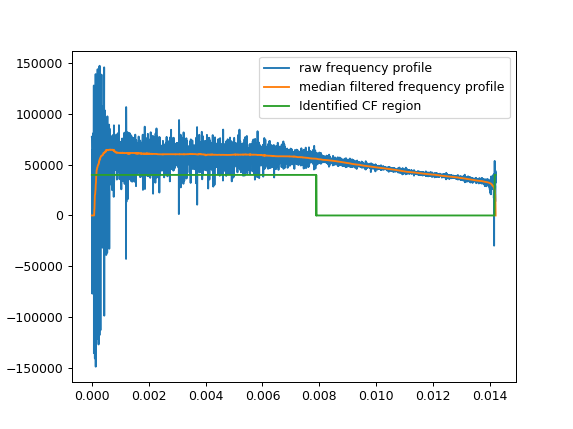

In [114]:
lep_fp = instantaneous_frequency_profile(leporinus,fs)
lep_clean_fp = median_filter(lep_fp, fs, medianfilter_size=0.001)
cf_region, fmrate_hzmsec = identify_cf_ish_regions(lep_clean_fp, fs, max_modulation=500)
plt.figure()
plt.plot(make_x_time(lep_fp,fs), lep_fp, label='raw frequency profile')
plt.plot(make_x_time(lep_fp,fs), lep_clean_fp, label='median filtered frequency profile')
plt.plot(make_x_time(cf_region,fs), cf_region*40000, label='Identified CF region')
plt.legend()

In [30]:
cf_region.size

4258

In [31]:
leporinus.size

4260

<IPython.core.display.Javascript object>


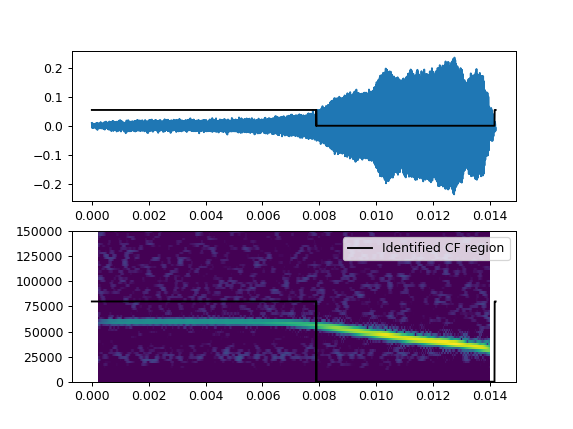

In [115]:
w ,s = visualise_call(leporinus, fs, fft_size=128)
w.plot(make_x_time(cf_region,fs), cf_region*np.max(leporinus[cf_region]), 'k')
s.plot(make_x_time(cf_region,fs), cf_region*80000, 'k',
       label='Identified CF region')
s.legend()

### Trying out instantaneous frequency for weirdly windowed synthetic calls:
The reason the 'standard' CF-FM segmentation failed for the leporinus call was because there was odd windowing which emphasised the lower frequency FM portion. The current system should also fail if i take the synthetic call above and oddly window it so the CF portion is de-emphasised. 

<IPython.core.display.Javascript object>


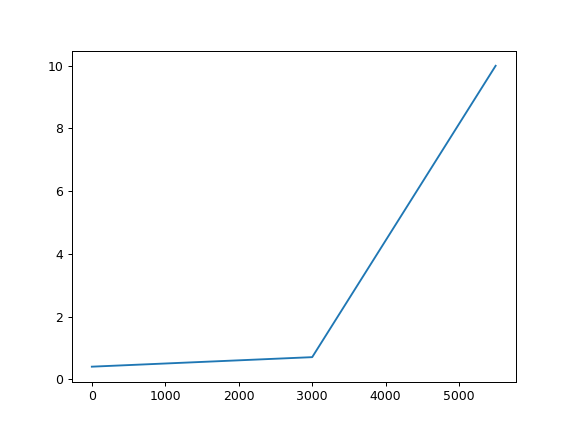

In [116]:
call_parameters = {'cf':(100000, 0.001),
                    'upfm':(100000, 0.005),
                    'downfm':(60000, 0.005),
                    }
cf_samples, upfm_samples, downfm_samples = [ int(syn_fs*call_parameters[each][1]) for each in ['cf','upfm','downfm']]

synthetic_lepo, _ = make_cffm_call(call_parameters, syn_fs)
# make a de-emphasis filter for the Cf part of the call
deemphasis = 1-signal.tukey(int(call_parameters['cf'][1]*syn_fs), 0.95)*0.8
# add 1's for the rest of the call
cf_deemphasis = np.concatenate((np.linspace(0.4,0.7, upfm_samples+cf_samples),
                               np.linspace(0.7,10,downfm_samples))
                              )
synthetic_cf_demp = synthetic_lepo * cf_deemphasis
synthetic_cf_demp /= np.max(synthetic_cf_demp)


plt.figure()
plt.plot(cf_deemphasis)

In [11]:
cf_deemphasis.shape

(5500,)

Following cf-deemphasis this is what our call looks like:

<IPython.core.display.Javascript object>


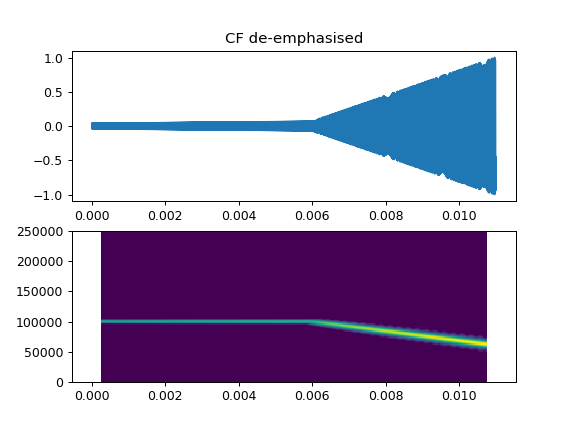

<IPython.core.display.Javascript object>


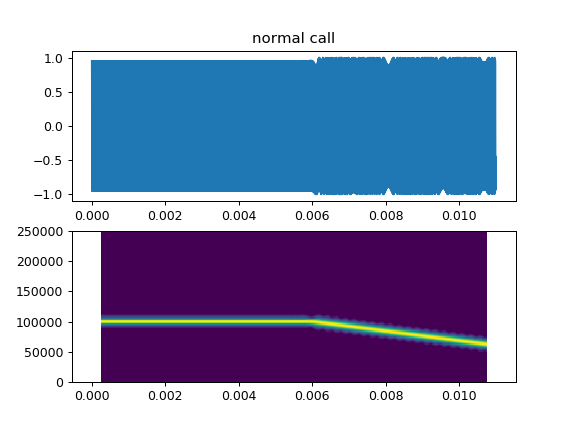

Text(0.5, 1.0, 'normal call')

In [117]:
w_de, s_de = visualise_call(synthetic_cf_demp, syn_fs, fft_size=256)
w_de.set_title('CF de-emphasised')
w, s = visualise_call(synthetic_lepo, syn_fs, fft_size=256)
w.set_title('normal call')

In [118]:
try:
    segment_and_show_cffm((synthetic_lepo, syn_fs))
except Exception as E:
    # print the Error message -- and thus allow the notebook to be run at one stretch..
    print(str(E))
    

Could not detect any FM parts...


And of course, why this happens is pretty clear. The peak frequency is estimated horribly wrong and so there is no difference between the lowpassed and highpassed versions of the call despite all the bandpassing in the world. 

In [119]:
peak_frequency, resolution = get_peak_frequency(synthetic_cf_demp, fs)
print(peak_frequency)

37363.63636363637


Compare the peak frequency from the oddly FM emphasised call to that of the original call:

In [120]:
print(get_peak_frequency(synthetic_lepo, syn_fs))

(100000.00000000001, 181.75209014903672)


In [121]:
cf, fm, _ = segment_call_into_cf_fm(synthetic_cf_demp, syn_fs, peak_percentage=0.98)

<IPython.core.display.Javascript object>


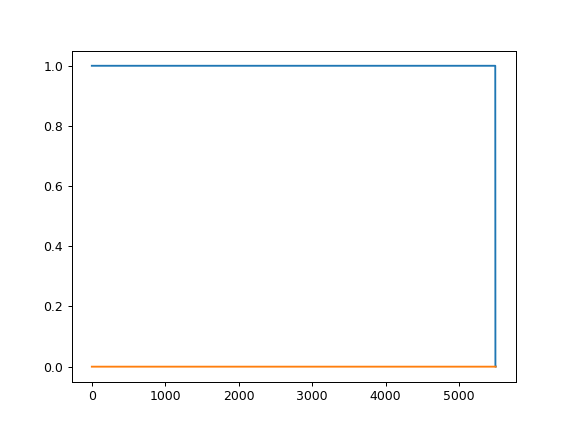

In [122]:
plt.figure()
plt.plot(cf)
plt.plot(fm)

In [124]:
cfdbrms, fmdbrms  = pre_process_for_segmentation(synthetic_cf_demp, syn_fs)

<IPython.core.display.Javascript object>


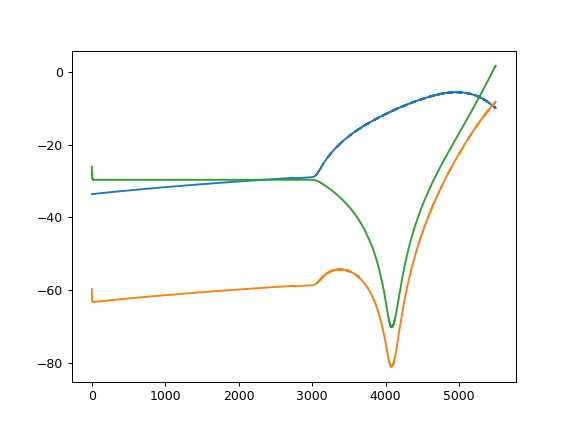

In [123]:
plt.figure()
plt.plot(cfdbrms)
plt.plot(fmdbrms)
plt.plot(fmdbrms-cfdbrms)

In [125]:
synthetic_lepo.size

5500

In [126]:
cf_region.size

4260

input signal size, pre filtering 5500
 signal size, post filtering 5500
input signal size, pre filtering 5499
 signal size, post filtering 5499


<IPython.core.display.Javascript object>


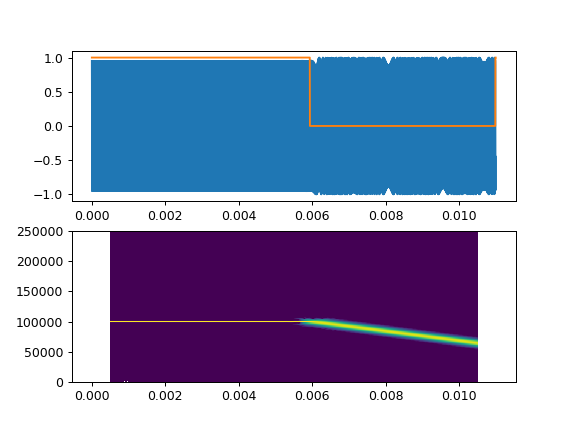

C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\matplotlib\axes\_axes.py:7747: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


In [127]:
cf_region, fmrate = segment_cf_regions(synthetic_lepo, syn_fs)
w,s = visualise_call(synthetic_lepo, syn_fs)
w.plot(make_x_time(cf_region, syn_fs),cf_region)

input signal size, pre filtering 5500
 signal size, post filtering 5500
input signal size, pre filtering 5499
 signal size, post filtering 5499


<IPython.core.display.Javascript object>


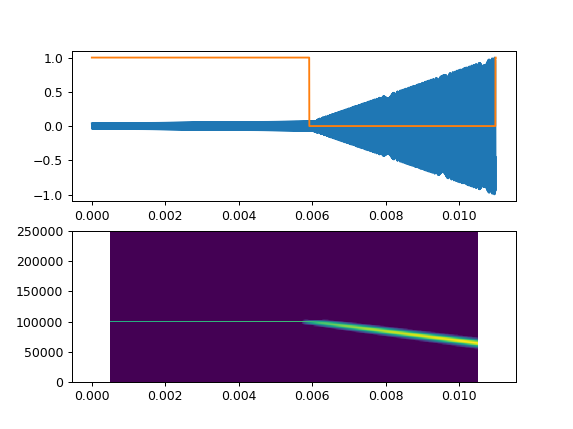

In [128]:
cf_region, fmrate = segment_cf_regions(synthetic_cf_demp, syn_fs)
w,s = visualise_call(synthetic_cf_demp, syn_fs)
w.plot(make_x_time(cf_region, syn_fs),cf_region)

#### Instantaneous frequency is pretty neat. 
The instantaneous frequency tracking method actually works *pretty* damn well even for calls with weird envelopes :P !!!